In [1]:
%matplotlib inline
#%matplotlib notebook
#%matplotlib widget
import matplotlib 
import numpy as np
import pandas as pd
import os, sys, time, pickle
#import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection    

from scipy import optimize
# use LaTeX, choose nice some looking fonts and tweak some settings
matplotlib.rc('font', family='serif')
matplotlib.rc('font', size=16)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('legend', handlelength=1.5)
matplotlib.rc('legend', frameon=True)
matplotlib.rc('xtick.major', pad=7)
matplotlib.rc('xtick', direction="in")
matplotlib.rc('ytick', direction="in")
matplotlib.rc('xtick', top = True)
matplotlib.rc('ytick', right =True )
matplotlib.rc('xtick.minor', pad=7)
matplotlib.rc('text', usetex=True)
# matplotlib.rc('text.latex', 
#               preamble=[r'\usepackage[T1]{fontenc}',
#                         r'\usepackage{amsmath}',
#                         r'\usepackage{txfonts}',
#                         r'\usepackage{textcomp}'])

matplotlib.rc('figure', figsize=(12, 9))

#plt.style.use(["default"])


In [2]:
psddatafolder = r"/home/jiyongso/mydocs/psddata/FILTERED"
psddatafolder2 = r"/home/jiyongso/mydocs/psddata"

# psd = pd.read_pickle(os.path.join(psddatafolder, "ch2data_2.pkl"))
# psd.columns=["TimeTag"]+list(np.arange(168))

# # # 앞으로 데이터 해석하는데 필요할 backgroun와  maximum value 를 column으로 채워 넣음.
# bgval = psd.loc[:, 5:35].apply(np.mean, axis=1)
# bgstd = psd.loc[:, 5:35].apply(np.std, axis=1)
# psd.insert(loc=1, column = "BgVal", value=bgval)
# psd.insert(loc=2, column = "BgStd", value=bgstd)
# psd.insert(loc=3, column = "MaxIndex", value=psd.loc[:, 0:100].apply(np.argmax, axis=1))
# psd.insert(loc=4, column = "MaxVal", value = psd.loc[:, 0:100].apply(np.max, axis=1))

# psd.sort_values("MaxVal", ascending=False, inplace=True)

# psd.to_pickle(os.path.join(psddatafolder, "ch2data_3.pkl"))

psd = pd.read_pickle(os.path.join(psddatafolder, "ch2data_3.pkl"))
smoothfitting=pickle.load(open(os.path.join(psddatafolder2, "smoothstepfit.pkl"), "rb"))
psd_to_remove = [505591, ]

In [57]:
def smoothstep(x, a, b, c, d):
    return a/(1.0+np.exp(-b*((x-c))))+d

def residual(p, x, y):
    return y-smoothstep(x, p[0], p[1], p[2], p[3])

def gaussian(x, a, x0, sig):
    return a*np.exp(-(x-x0)**2/(2*sig**2))


def residual_psd(p, x, y):
    return (y-(gaussian(x, p[0], p[1], p[2])+
               gaussian(x, p[3], p[4], p[5])+p[6]))

def psd_fit(x, a1, c1, s1, a2, c2, s2, bg):
    return (gaussian(x, a1, c1, s1)+
               gaussian(x, a2, c2, s2)+bg)

def plotsmottfit(index):
    x=np.arange(159)
    p = smf.loc[index, ["a", "b", "c", "d"]]
    y1 = smoothstep(x, p[0], p[1], p[2]+5, p[3])
    y2 = psd.loc[index, np.arange(159)]
    plt.plot(x, y1, "r-", lw=4, label="smoothfit")
    plt.plot(x, y2, "bo", ms=6, label="data")
    plt.xlabel("Channel [2ns unit]")
    #plt.yscale('log')
    plt.legend()


In [7]:
smf1=[a[0] for a in smoothfitting]
smf2=[a[1][0] for a in smoothfitting]
smf3=[a[1][1] for a in smoothfitting]
smf = pd.DataFrame(data = smf2, index = smf1, columns = ("a", "b", "c", "d"))
smf.insert(loc = 4, column = "pcov", value = smf3 )

index1 = smf["pcov"]<=3
psd1 = psd[index1]
smf1 = smf[index1]
index2 = smf1["b"]>0.1
psd1 = psd1[index2]
smf1 = smf1[index2]

In [16]:
inds = smf1.index
#inds = smf1.index
area1=[]
area2=[]
for ind in inds :
    #print(ind)
    mind = int(smf1.loc[ind, "c"].round())+5
    area1.append((psd1.loc[ind, mind:mind+10]).sum()-(psd1.loc[ind, "BgVal"])*11)
    area2.append((psd1.loc[ind, mind:mind+50]).sum()-(psd1.loc[ind, "BgVal"])*51)
aa = (np.array(area2)-np.array(area1))/np.array(area2)
psdresult=pd.DataFrame({"Qshort": area1, "Qlong" : area2, "PsdValue": aa }, 
                       index = inds)
#psdresult.to_pickle(os.path.join(psddatafolder, "psdresult_1.pkl"))

In [4]:
psdresult = pd.read_pickle(os.path.join(psddatafolder, "psdresult_1.pkl"))

In [5]:
psdresult["PsdValue"].min(), psdresult["PsdValue"].max()

(-5.230890464933033, 42.067193675888916)

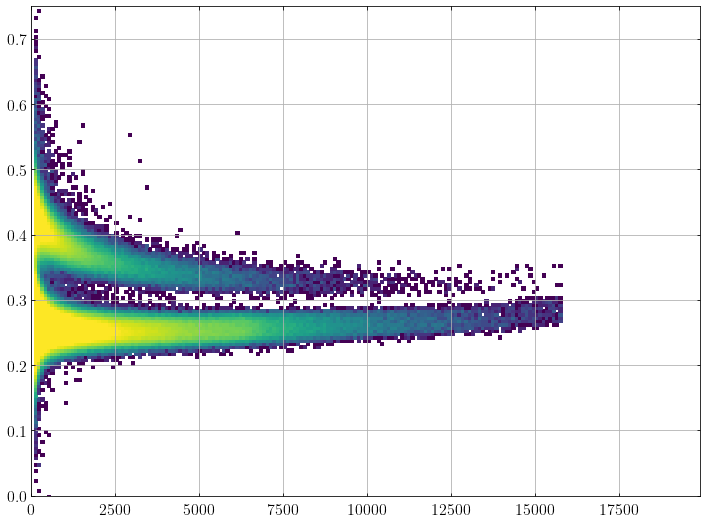

In [19]:
inds = smf1.index
result = plt.hist2d(psd1.loc[inds]["MaxVal"], psdresult["PsdValue"] , 
                   bins=[np.arange(0, 20000, 100), np.arange(-1, 1, 0.005)], 
                   norm=matplotlib.colors.LogNorm())
plt.ylim([0.0, 0.75])
plt.clim(1, 1360)
#plt.xlim(200, 17500)
plt.grid()
#print(aa.min(), aa.max())

In [114]:
result[1]

array([    0,   100,   200,   300,   400,   500,   600,   700,   800,
         900,  1000,  1100,  1200,  1300,  1400,  1500,  1600,  1700,
        1800,  1900,  2000,  2100,  2200,  2300,  2400,  2500,  2600,
        2700,  2800,  2900,  3000,  3100,  3200,  3300,  3400,  3500,
        3600,  3700,  3800,  3900,  4000,  4100,  4200,  4300,  4400,
        4500,  4600,  4700,  4800,  4900,  5000,  5100,  5200,  5300,
        5400,  5500,  5600,  5700,  5800,  5900,  6000,  6100,  6200,
        6300,  6400,  6500,  6600,  6700,  6800,  6900,  7000,  7100,
        7200,  7300,  7400,  7500,  7600,  7700,  7800,  7900,  8000,
        8100,  8200,  8300,  8400,  8500,  8600,  8700,  8800,  8900,
        9000,  9100,  9200,  9300,  9400,  9500,  9600,  9700,  9800,
        9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700,
       10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600,
       11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500,
       12600, 12700,

[ 2.72440576e+02  2.62639743e-01  1.21983042e-02  1.85320147e+01
  3.25737784e-01  1.01750545e-02 -1.44346629e-01]


Text(0.5, 1.0, 'FOM=1.1977 $\\pm$ 0.1028')

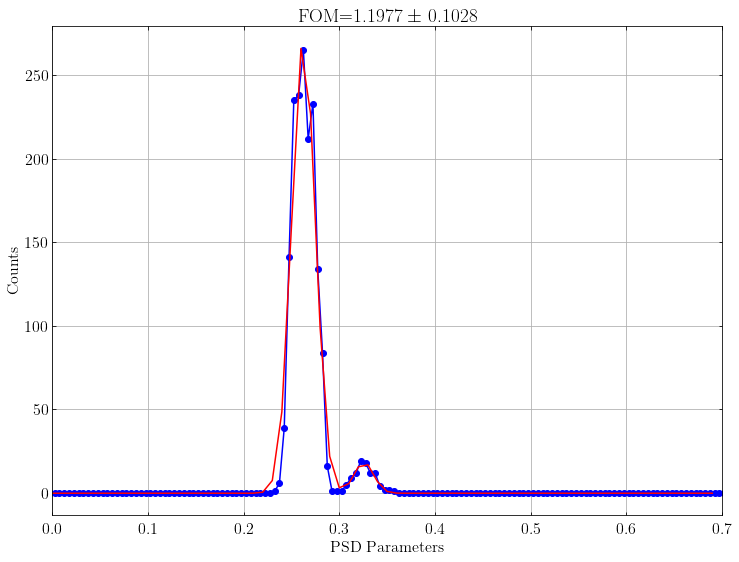

In [141]:
fomx=0.5*(result[2][1:]+result[2][:-1])
fomy = result[0][95:105, :].sum(axis=0)
p0=[fomy.max(), 0.252, 0.012, 300, 0.33, 0.012, 10]
ydata = psd_fit(fomx, p0[0], p0[1], p0[2], p0[3], p0[4], p0[5], p0[6])
popt, pcov = optimize.curve_fit(psd_fit, fomx, fomy, p0)
xx = np.arange(0.0, 0.7, 0.01)
print(popt)
plt.plot(fomx, fomy, "bo-")
plt.plot(xx, gaussian(xx, popt[0], popt[1], popt[2])+gaussian(xx, popt[3], popt[4], popt[5])+popt[6], 'r-')
plt.xlim([0.0, 0.7])
#plt.ylim([1, 500000])
#plt.yscale('log')
plt.grid()
plt.xlabel("PSD Parameters")
plt.ylabel("Counts")
g1, g2 = np.abs(popt[2]), np.abs(popt[5])
fomv = np.abs(popt[1]-popt[4])/(2.3548*(g1+g2))
fit_diag = pcov.diagonal()
c1_err, c2_err, g1_err, g2_err = np.sqrt(fit_diag[1]), np.sqrt(fit_diag[4]),\
    np.sqrt(fit_diag[2]), np.sqrt(fit_diag[5])  
err1=np.sqrt(c1_err**2+c2_err**2)
cc1=np.abs(popt[1]-popt[4])
err2=2.3548*np.sqrt(g1_err**2+g2_err**2)
gg2 = np.abs(2.3548*(g1+g2))
fome = np.abs(fomv)*np.sqrt(err1**2/cc1**2+err2**2/gg2**2)
plt.title("FOM=%6.4f $\pm$ %6.4f"%(fomv, fome))

In [102]:
pcov.diagonal()

array([3.80363879e+03, 2.95954876e-09, 2.99506400e-09, 3.57026920e+03,
       3.70838237e-07, 3.75580575e-07, 3.03109856e+01])

In [113]:
2*np.sqrt(2*np.log(2))

2.3548200450309493

In [145]:
fom_c = [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000 ]
fom_v = [1.7869, 1.6728, 1.5382, 1.4432, 1.3827, 1.2818, 1.2335, 1.1686, 1.1977]
fom_e = [0.00304, 0.0454, 0.0678, 0.0846, 0.1200, 0.1107, 0.1058, 0.0897, 0.1028]

<ErrorbarContainer object of 3 artists>

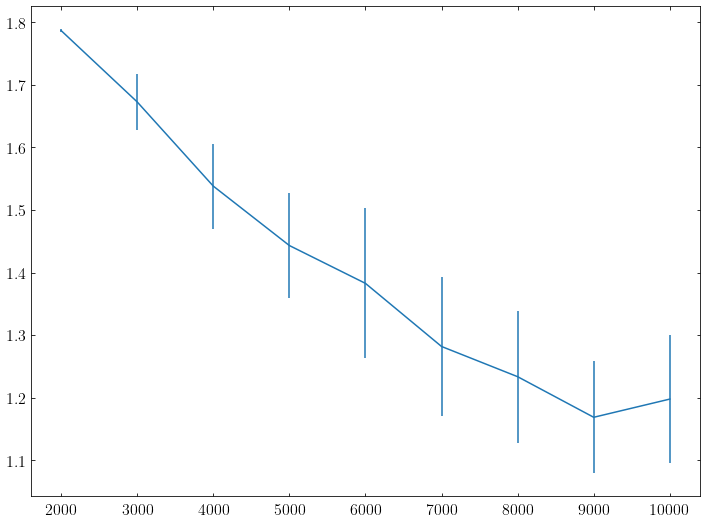

In [146]:
plt.errorbar(fom_c, fom_v, fom_e)

In [61]:
psdresult

,Qshort,Qlong,PsdValue
1860390,145609.967742,201843.032258,0.278598
570282,143835.161290,206633.838710,0.303913
2101019,144808.645161,205079.354839,0.293890
923588,147402.935484,204678.064516,0.279830
834923,145989.741935,204468.258065,0.286003
...,...,...,...
736831,813.548387,1067.451613,0.237859
481238,870.741935,1224.258065,0.288759
649223,840.064516,1121.935484,0.251236
815433,791.225806,1079.774194,0.267230


In [18]:
psd

,TimeTag,BgVal,BgStd,MaxIndex,MaxVal,0,1,2,3,4,...,158,159,160,161,162,163,164,165,166,167
1860390,1501647601236436,19.548387,3.046296,59,15787,24,19,19,21,20,...,75,69,68,65,64,76,68,61,66,60
570282,459835841633703,20.258065,2.564871,59,15783,20,23,18,22,17,...,73,77,80,71,69,63,59,65,63,65
2101019,1695422026746984,19.032258,3.207691,59,15775,21,20,20,20,20,...,67,66,62,60,60,67,80,80,76,72
923588,745813135262483,20.096774,2.656153,58,15774,20,21,23,20,21,...,76,72,68,67,65,62,56,65,57,57
834923,673815462908327,20.387097,2.858800,59,15769,19,18,21,20,23,...,62,70,66,69,75,68,73,68,69,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736831,594459843867874,16.677419,2.922517,48,119,16,15,11,17,20,...,21,15,19,22,14,21,22,20,15,16
481238,387713179527873,17.387097,2.743643,48,119,19,18,21,12,17,...,23,20,20,19,23,26,5,18,22,19
649223,523462374573999,17.903226,3.072824,48,119,19,17,19,20,17,...,16,20,15,17,18,20,18,17,18,22
815433,658098931309748,18.161290,3.253750,48,119,16,20,19,20,18,...,20,19,24,21,14,17,22,12,20,21


In [19]:
psdresult

,Qshort,Qlong,PsdValue
1860390,145609.967742,201843.032258,0.278598
570282,143835.161290,206633.838710,0.303913
2101019,144808.645161,205079.354839,0.293890
923588,147402.935484,204678.064516,0.279830
834923,145989.741935,204468.258065,0.286003
...,...,...,...
736831,813.548387,1067.451613,0.237859
481238,870.741935,1224.258065,0.288759
649223,840.064516,1121.935484,0.251236
815433,791.225806,1079.774194,0.267230
